In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import keras

In [2]:
print('tf version:',tf.__version__,'\n' ,'keras version:',keras.__version__,'\n' ,'numpy version:',np.__version__)

tf version: 2.15.0 
 keras version: 2.15.0 
 numpy version: 1.23.5


In [4]:
solarpower = pd.read_csv(r"C:\Users\Dell\mlre\PV_Elec_Gas3.csv",header = None,skiprows=1 ,
                         names = ['date','cum_power','Elec_kW', 'Gas_mxm'], sep=',',usecols = [0,1,2,3],
                     
parse_dates={'dt' : ['date']}, infer_datetime_format=True,index_col='dt')
print(solarpower.head(2))

            cum_power  Elec_kW  Gas_mxm
dt                                     
2011-10-26        0.1     15.1      9.0
2011-10-27       10.2      7.4      9.2


In [5]:
solarpower2 = solarpower.shift(periods=1, freq='D', axis=0)
solarpower['cum_power_shift'] = solarpower2.loc[:,'cum_power']
solarpower['day_power'] = solarpower['cum_power'].values - solarpower['cum_power_shift']
solarpower.iloc[0:1].day_power.value = 0.
A = solarpower.dropna()
del A['cum_power'], A['cum_power_shift']
solarpower = A

In [6]:
solarpower.head(2), solarpower.tail(2)

(            Elec_kW  Gas_mxm  day_power
 dt                                     
 2011-10-27      7.4      9.2       10.1
 2011-10-28      5.8      8.0       10.0,
             Elec_kW  Gas_mxm  day_power
 dt                                     
 2020-11-09     14.0     10.0        5.0
 2020-11-10     14.0      9.0        3.0)

In [7]:
X_train = solarpower[:'2018-10-28']
X_valid = solarpower['2018-10-29':'2019-10-28'] # is 365 days
X_train.shape, X_valid.shape

((2559, 3), (365, 3))

In [8]:
X_train.tail(2), X_valid.head(2)

(            Elec_kW  Gas_mxm  day_power
 dt                                     
 2018-10-27     16.0      9.0        2.0
 2018-10-28      7.0     11.0        8.0,
             Elec_kW  Gas_mxm  day_power
 dt                                     
 2018-10-29     10.0     13.0        7.0
 2018-10-30     15.0     14.0        2.0)

In [9]:
def my_split_window(series, window_in, window_out):
    '''
    the series is split into output sequences of length window_in and 
    output sequences of lenght window_out
    returns arrays X, y
    '''
    X = []
    y = []
    n_steps = len(series) - window_in + 1
    for step in range(n_steps):
        if (step + window_in + window_out) > (len(series)):
                    break
        X_w = []
        for i in range(window_in):
            X_w.append(series[i+step])
            y_w = []
            for j in range(window_out):
                n = i + j + step + 1

                y_w.append(series[n])
        X_w = np.array(X_w)
        X.append(X_w)
        y_w = np.array(y_w)
        y.append(y_w)   
    X = np.array(X)
    y = np.array(y)
    return X, y

In [10]:
series = [10,20,30,40,50,60,70,80,90]
window_in = 3
window_out = 2
X_, y_ = my_split_window(series, window_in, window_out)
X_, y_

(array([[10, 20, 30],
        [20, 30, 40],
        [30, 40, 50],
        [40, 50, 60],
        [50, 60, 70]]),
 array([[40, 50],
        [50, 60],
        [60, 70],
        [70, 80],
        [80, 90]]))

In [11]:
X_.shape, y_.shape

((5, 3), (5, 2))

In [12]:
window_in = 365
window_out = 365
X, y = my_split_window(X_train.day_power.values,  window_in, window_out)
# print a sample
for i in range(3):
    print(X[i][-2:], y[i][-2:])

[8.2 8.7] [5. 9.]
[8.7 1.5] [9. 4.]
[1.5 2. ] [4. 6.]


In [13]:
n_features = 1 # it is a series
window_in = 365
window_out = 365

In [14]:
X = X.reshape((X.shape[0], X.shape[1], n_features ))

In [15]:
def LSTM_cnn_model(window_in, window_out, n_features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(32, return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu',
                                input_shape=(window_in, n_features)))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(window_out))
    return model

In [16]:
model = LSTM_cnn_model(window_in, window_out, n_features)
# compile the model:
model.compile(optimizer='adam', loss='mae')

In [17]:
history = model.fit(X, y, epochs=20, verbose=0)

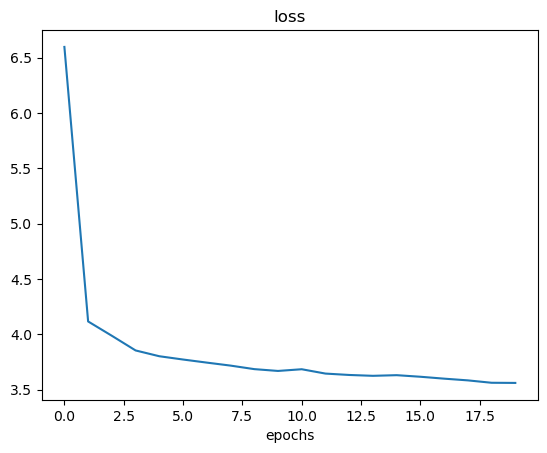

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.show()

In [19]:
X_input = X_valid.day_power.ravel()
X_input = X_input.reshape(1, window_in, n_features)

y_hat = model.predict(X_input, verbose=0)

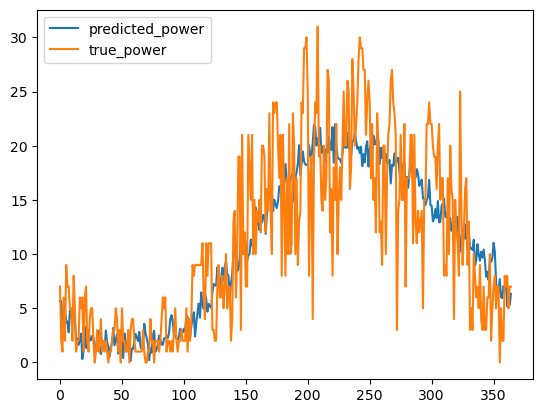

In [20]:
plt.plot(y_hat[0], label='predicted_power')
y_true = X_valid.day_power.values
plt.plot(y_true, label='true_power')
plt.legend()
plt.show()

In [21]:
first_r2_score = r2_score(y_true, y_hat[0]) # Best possible score is 1.0 
first_mae = mean_absolute_error(y_true, y_hat[0])
print('r2_score %.5f' % first_r2_score)
print('mae %.2f' % first_mae)

r2_score 0.65967
mae 3.65


In [22]:
def cumulate(series, start=0):
    '''
    start is the starting cumulative power, the series is the daily solar power
    a list with daily cumulative power is the result
    '''
    cum = [start]
    for i in range(len(series)):
        sum_plus = cum[i] + series[i]
        cum.append(sum_plus)
    return cum

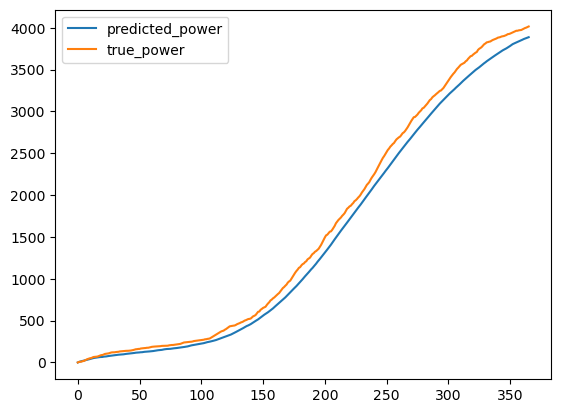

In [23]:
y_true_cumulative = cumulate(y_true)
y_predicted_cumulative = cumulate(y_hat[0])

plt.plot(y_predicted_cumulative, label='predicted_power')
plt.plot(y_true_cumulative, label='true_power')
plt.legend()
plt.show()

In [24]:
true_cumulative_power_after_one_year = int(y_true_cumulative[-1])
predicted_cumulative_power_after_one_year = int(y_predicted_cumulative[-1])
print('true cumulative power after one year:', true_cumulative_power_after_one_year)
print('predicted cumulative power after one year:', predicted_cumulative_power_after_one_year)

acc_one_year = 1- (true_cumulative_power_after_one_year - predicted_cumulative_power_after_one_year)/true_cumulative_power_after_one_year
acc_one_year = acc_one_year * 100

print('accuracy after one year: %.2f' %  acc_one_year,'%')
print('r2 score %.5f ' % r2_score(y_true_cumulative, y_predicted_cumulative))
print('mae  %.2f' % mean_absolute_error(y_true_cumulative, y_predicted_cumulative))

true cumulative power after one year: 4015
predicted cumulative power after one year: 3886
accuracy after one year: 96.79 %
r2 score 0.99073 
mae  117.70


In [25]:
X_train = X_train.copy()
X_valid = X_valid.copy()
X_train['Gas_plus_Elek'] = X_train.Gas_mxm + X_train.Elec_kW
X_valid['Gas_plus_Elek'] = X_valid.Gas_mxm + X_valid.Elec_kW

In [26]:
window_in = 365
window_out = 365
X, y = my_split_window(X_train.day_power.values,  window_in, window_out)
# print a sample
for i in range(3):
    print(X[i][-2:], y[i][-2:])

[8.2 8.7] [5. 9.]
[8.7 1.5] [9. 4.]
[1.5 2. ] [4. 6.]


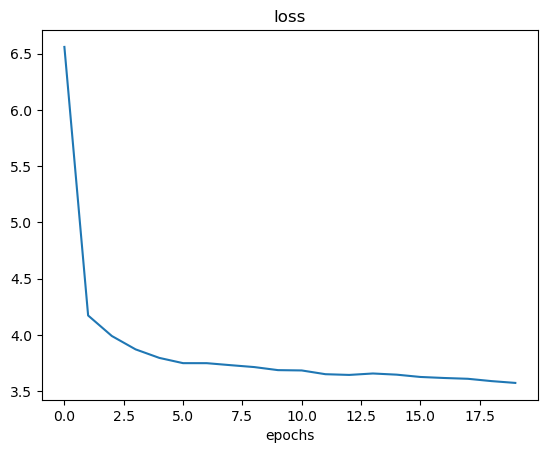

In [27]:
n_features = 1 # it is a series
window_in = 365
window_out = 365
# we have to reshape from (samples, timesteps) to (samples, timesteps, n_features)
X = X.reshape((X.shape[0], X.shape[1], n_features ))



model = LSTM_cnn_model(window_in, window_out, n_features)
# compile the model:
model.compile(optimizer='adam', loss='mae')

# fit model
history = model.fit(X, y, epochs=20, verbose=0)

# graph of the loss shows convergence
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.show()

In [28]:
X_input = X_train[-365:].day_power.ravel()
X_input = X_input.reshape(1, window_in, n_features)

y_hat = model.predict(X_input, verbose=0)

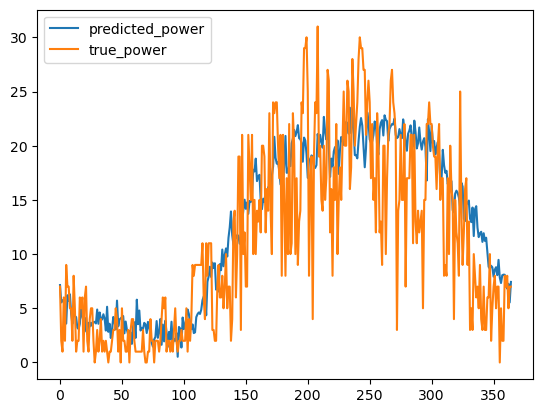

In [29]:
plt.plot(y_hat[0], label='predicted_power')
y_true = X_valid.day_power.values
plt.plot(y_true, label='true_power')
plt.legend()
plt.show()

In [30]:
first_r2_score = r2_score(y_true, y_hat[0]) # Best possible score is 1.0 
first_mae = mean_absolute_error(y_true, y_hat[0])
print('r2_score %.5f' % first_r2_score)
print('mae %.2f' % first_mae)

r2_score 0.62060
mae 3.90


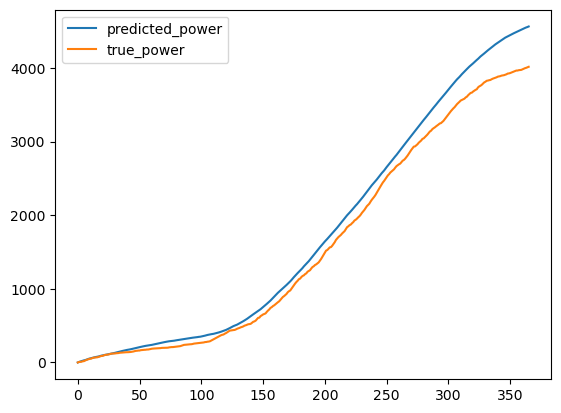

In [31]:
y_true_cumulative = cumulate(y_true)
y_predicted_cumulative = cumulate(y_hat[0])

plt.plot(y_predicted_cumulative, label='predicted_power')
plt.plot(y_true_cumulative, label='true_power')
plt.legend()
plt.show()

In [32]:
true_cumulative_power_after_one_year = int(y_true_cumulative[-1])
predicted_cumulative_power_after_one_year = int(y_predicted_cumulative[-1])
print('true cumulative power after one year:', true_cumulative_power_after_one_year)
print('predicted cumulative power after one year:', predicted_cumulative_power_after_one_year)

acc_one_year = 1- (true_cumulative_power_after_one_year - predicted_cumulative_power_after_one_year)/true_cumulative_power_after_one_year
acc_one_year = acc_one_year * 100

print('accuracy after one year: %.2f' %  acc_one_year,'%')
print('r2 score %.5f ' % r2_score(y_true_cumulative, y_predicted_cumulative))
print('mae  %.2f' % mean_absolute_error(y_true_cumulative, y_predicted_cumulative))

true cumulative power after one year: 4015
predicted cumulative power after one year: 4562
accuracy after one year: 113.62 %
r2 score 0.97397 
mae  172.64
